In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [15]:
# Đọc dữ liệu
df = pd.read_csv('data/dataset_with_features.csv')

df_ham = df[df['label'] == 0].copy()
df_spam = df[df['label'] == 1].copy()

## Tổng quan về bộ dữ liệu

In [16]:
# Kiểm tra thông tin chung về dữ liệu
print(df.info())

print('-'*50)
# Thống kê khuyết tại các cột
print('\nThống kê khuyết tại các cột:')
print(df.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2603 entries, 0 to 2602
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   content           2603 non-null   object 
 1   label             2603 non-null   int64  
 2   has_url           2603 non-null   int64  
 3   has_phone_number  2603 non-null   int64  
 4   sender_type       2603 non-null   object 
 5   misspelled_count  2603 non-null   int64  
 6   leet_count        2603 non-null   int64  
 7   total_tokens      2603 non-null   int64  
 8   misspelled_pct    2603 non-null   float64
 9   leet_pct          2603 non-null   float64
dtypes: float64(2), int64(6), object(2)
memory usage: 203.5+ KB
None
--------------------------------------------------

Thống kê khuyết tại các cột:
content             0
label               0
has_url             0
has_phone_number    0
sender_type         0
misspelled_count    0
leet_count          0
total_tokens        0
mis

In [17]:
# Kiểm tra trùng lặp
print('\nThống kê trùng lặp theo dòng dữ liệu:')
print(df.duplicated().sum())

print('\nThống kê trùng lặp theo cột content:')
print(df.duplicated(subset=['content']).sum())





Thống kê trùng lặp theo dòng dữ liệu:
0

Thống kê trùng lặp theo cột content:
0


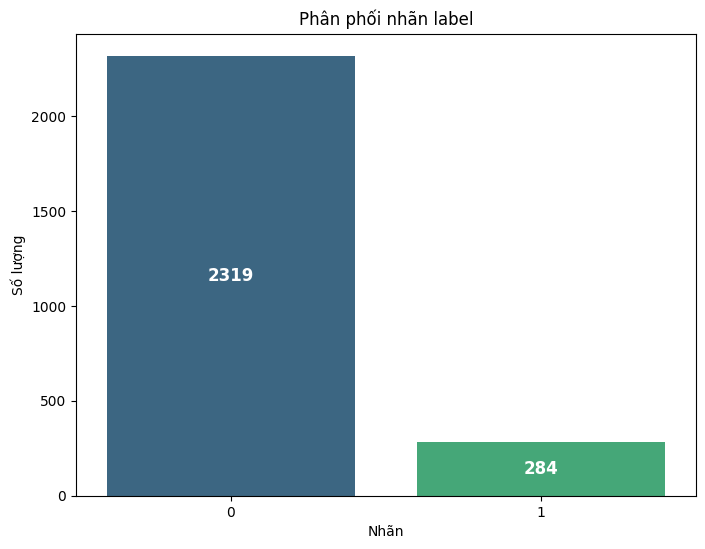

In [18]:
# Kiểm tra phân phối nhãn label
plt.figure(figsize=(8,6))
ax = sns.countplot(data=df, x='label', hue='label', palette='viridis', legend=False)
plt.title('Phân phối nhãn label')
plt.xlabel('Nhãn')
plt.ylabel('Số lượng')

# Thêm số liệu cụ thể vào giữa cột
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', 
                (p.get_x() + p.get_width() / 2, height / 2), 
                ha='center', va='center', color='white', fontsize=12, fontweight='bold')

plt.show()


## Phân tích các đặc trưng có sẵn

### Phân loại URL và SĐT

Tỷ lệ tin nhắn có URL trong từng nhóm Spam và Ham

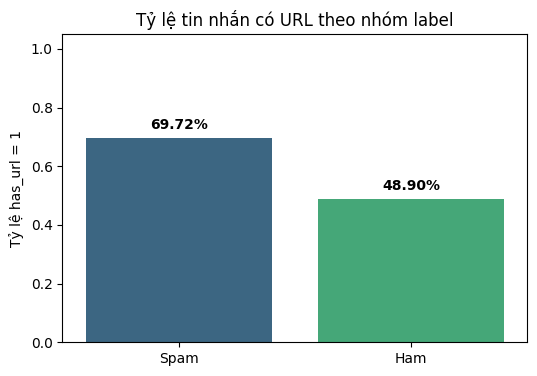

In [19]:
# Tính tỷ lệ tin nhắn có chứa URL trong từng nhóm
rate_spam_has_url = df_spam['has_url'].mean()
rate_ham_has_url = df_ham['has_url'].mean()

# Chuẩn bị dữ liệu để vẽ
rates = [rate_spam_has_url, rate_ham_has_url]
groups = ['Spam', 'Ham']

plt.figure(figsize=(6,4))
ax = sns.barplot(x=groups, y=rates, hue=groups, palette='viridis', legend=False)

# Thêm giá trị cụ thể lên mỗi cột
for i, v in enumerate(rates):
    ax.text(i, v + 0.02, f'{v:.2%}', ha='center', va='bottom', fontweight='bold')

plt.ylim(0, 1.05)
plt.ylabel('Tỷ lệ has_url = 1')
plt.title('Tỷ lệ tin nhắn có URL theo nhóm label')
plt.show()



Tỷ lệ tin nhắn có SĐT trong từng nhóm Spam và Ham

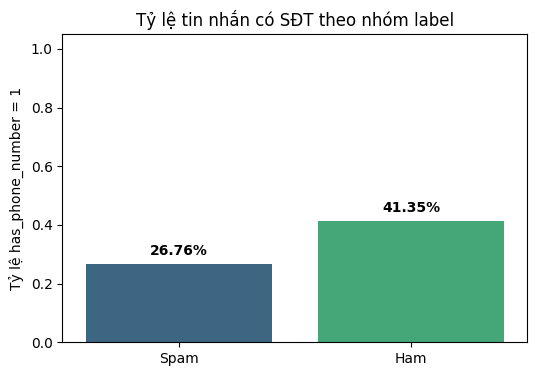

In [20]:
# Tính tỷ lệ tin nhắn có chứa URL trong từng nhóm
rate_spam_has_phone_number = df_spam['has_phone_number'].mean()
rate_ham_has_phone_number = df_ham['has_phone_number'].mean()

# Chuẩn bị dữ liệu để vẽ
rates = [rate_spam_has_phone_number, rate_ham_has_phone_number]
groups = ['Spam', 'Ham']

plt.figure(figsize=(6,4))
ax = sns.barplot(x=groups, y=rates, hue=groups, palette='viridis', legend=False)

# Thêm giá trị cụ thể lên mỗi cột
for i, v in enumerate(rates):
    ax.text(i, v + 0.02, f'{v:.2%}', ha='center', va='bottom', fontweight='bold')

plt.ylim(0, 1.05)
plt.ylabel('Tỷ lệ has_phone_number = 1')
plt.title('Tỷ lệ tin nhắn có SĐT theo nhóm label')
plt.show()



***Nhận xét:***

### Phân loại người gửi

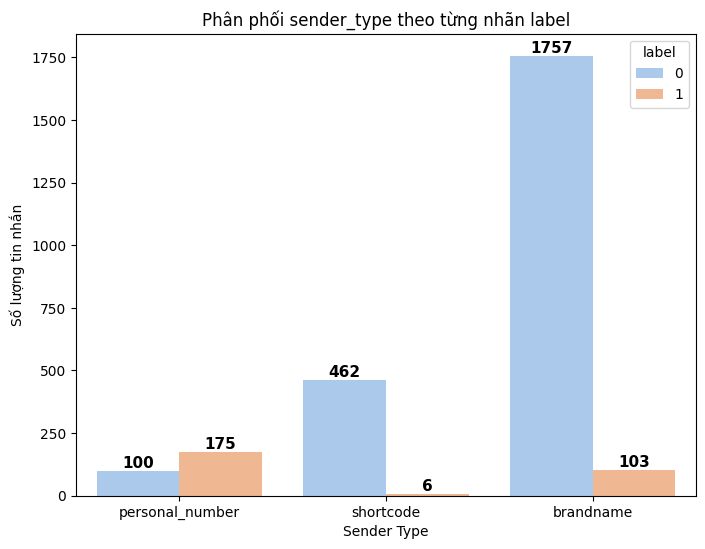

In [21]:
plt.figure(figsize=(8,6))
ax = sns.countplot(data=df, x='sender_type', hue='label', palette='pastel')
plt.title('Phân phối sender_type theo từng nhãn label')
plt.xlabel('Sender Type')
plt.ylabel('Số lượng tin nhắn')
plt.legend(title='label', labels=[0, 1])

# Thêm số liệu trên đỉnh mỗi cột
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}', 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.show()


***Nhận xét:***

## Feature Engineering cơ bản (theo paper)

### Misspelled words

Đã thử thực hiện trong file features.py

Correlation với label:
label               1.000000
misspelled_pct     -0.017847
total_tokens       -0.077811
leet_pct           -0.093910
misspelled_count   -0.104447
leet_count         -0.144017
Name: label, dtype: float64




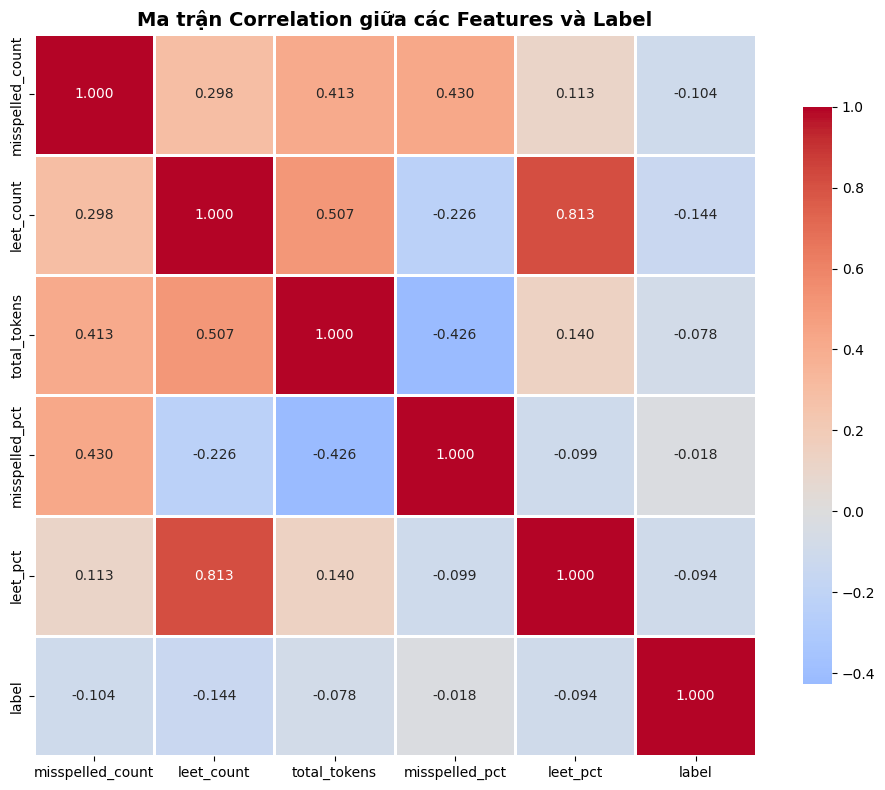


So sánh giá trị trung bình của features giữa Ham (0) và Spam (1):
       misspelled_count  leet_count  total_tokens  misspelled_pct  leet_pct
label                                                                      
0              7.006468    1.743855     33.864597       24.599237  4.823614
1              5.676056    1.000000     29.672535       23.544437  3.592077


Tỷ lệ Spam/Ham (>1 nghĩa là Spam cao hơn):
misspelled_pct      0.957121
total_tokens        0.876211
misspelled_count    0.810117
leet_pct            0.744686
leet_count          0.573442
dtype: float64


In [22]:
# Phân tích correlation giữa các feature với label
import numpy as np

# Chọn các cột cần phân tích
feature_cols = ['misspelled_count', 'leet_count', 'total_tokens', 'misspelled_pct', 'leet_pct']
correlation_data = df[feature_cols + ['label']]

# Tính ma trận correlation
correlation_matrix = correlation_data.corr()

# Hiển thị correlation với label
print("Correlation với label:")
print(correlation_matrix['label'].sort_values(ascending=False))
print("\n" + "="*50 + "\n")

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.3f', square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Ma trận Correlation giữa các Features và Label', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Phân tích chi tiết hơn: So sánh giá trị trung bình của features giữa Ham và Spam
print("\nSo sánh giá trị trung bình của features giữa Ham (0) và Spam (1):")
print("="*70)
comparison = df.groupby('label')[feature_cols].mean()
print(comparison)
print("\n")

# Tính tỷ lệ (Spam/Ham) để xem feature nào khác biệt nhiều nhất
ratio = comparison.loc[1] / comparison.loc[0]
print("Tỷ lệ Spam/Ham (>1 nghĩa là Spam cao hơn):")
print(ratio.sort_values(ascending=False))

C:\Users\duyng\AppData\Local\Temp\ipykernel_31592\3489034055.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='label', y='misspelled_pct', ax=axes[0], palette='Set2')
C:\Users\duyng\AppData\Local\Temp\ipykernel_31592\3489034055.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='label', y='leet_pct', ax=axes[1], palette='Set2')


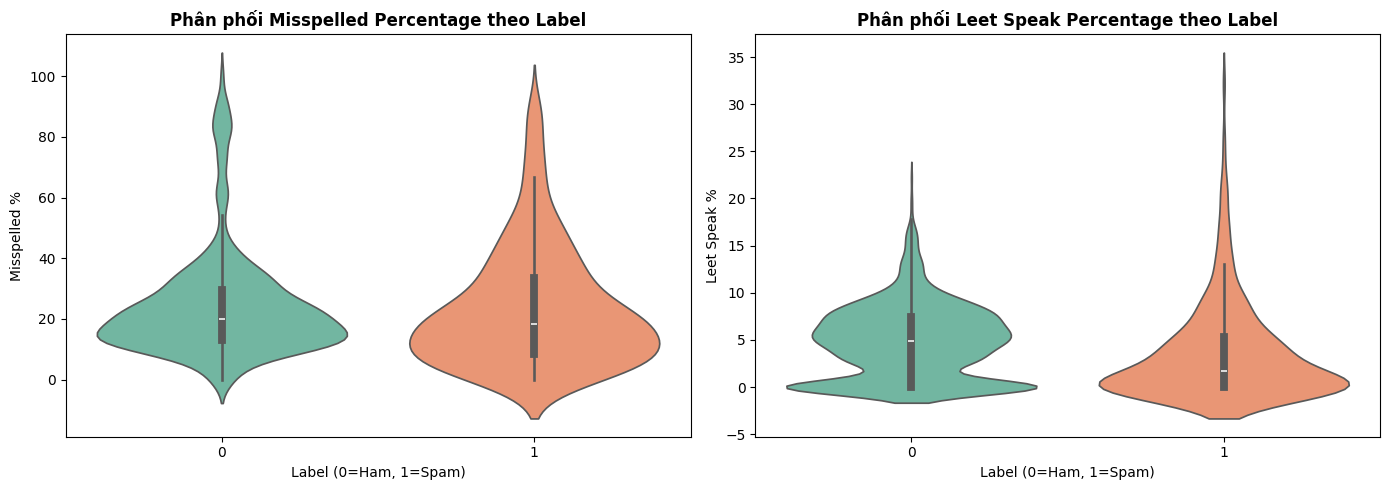

In [23]:
# Violin plot để xem distribution chi tiết hơn
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Misspelled percentage
sns.violinplot(data=df, x='label', y='misspelled_pct', ax=axes[0], palette='Set2')
axes[0].set_title('Phân phối Misspelled Percentage theo Label', fontweight='bold')
axes[0].set_xlabel('Label (0=Ham, 1=Spam)')
axes[0].set_ylabel('Misspelled %')

# Leet speak percentage
sns.violinplot(data=df, x='label', y='leet_pct', ax=axes[1], palette='Set2')
axes[1].set_title('Phân phối Leet Speak Percentage theo Label', fontweight='bold')
axes[1].set_xlabel('Label (0=Ham, 1=Spam)')
axes[1].set_ylabel('Leet Speak %')

plt.tight_layout()
plt.show()

In [24]:
# Phân tích từ khóa trong Spam vs Ham
from collections import Counter
from underthesea import word_tokenize
import re

def extract_words(text):
    """Tách từ và chuẩn hóa"""
    if not isinstance(text, str):
        return []
    # Tách từ
    words = word_tokenize(text.lower(), format="text").split()
    # Chỉ giữ các từ có ý nghĩa (loại bỏ số, ký tự đặc biệt)
    words = [w.replace('_', ' ') for w in words if re.search(r'[a-zàáảãạăằắẳẵặâầấẩẫậèéẻẽẹêềếểễệìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵđ]', w)]
    return words

# Tách từ cho tất cả tin nhắn
print("Đang tách từ cho tất cả tin nhắn...")
df['words'] = df['content'].apply(extract_words)

# Đếm từ trong Spam
spam_words = []
for words in df[df['label'] == 1]['words']:
    spam_words.extend(words)
spam_counter = Counter(spam_words)

# Đếm từ trong Ham
ham_words = []
for words in df[df['label'] == 0]['words']:
    ham_words.extend(words)
ham_counter = Counter(ham_words)

print(f"✓ Tổng số từ trong Spam: {len(spam_words):,}")
print(f"✓ Tổng số từ trong Ham: {len(ham_words):,}")
print(f"✓ Số từ unique trong Spam: {len(spam_counter):,}")
print(f"✓ Số từ unique trong Ham: {len(ham_counter):,}")

Đang tách từ cho tất cả tin nhắn...
✓ Tổng số từ trong Spam: 8,488
✓ Tổng số từ trong Ham: 77,472
✓ Số từ unique trong Spam: 2,348
✓ Số từ unique trong Ham: 5,133


In [25]:
# Top 30 từ phổ biến trong Spam
print("\n" + "="*60)
print("TOP 30 TỪ PHỔ BIẾN NHẤT TRONG SPAM")
print("="*60)
for word, count in spam_counter.most_common(30):
    print(f"{word:<20} : {count:>5} lần")

print("\n" + "="*60)
print("TOP 30 TỪ PHỔ BIẾN NHẤT TRONG HAM")
print("="*60)
for word, count in ham_counter.most_common(30):
    print(f"{word:<20} : {count:>5} lần")


TOP 30 TỪ PHỔ BIẾN NHẤT TRONG SPAM
bạn                  :    90 lần
k                    :    88 lần
ban                  :    84 lần
ngay                 :    75 lần
de                   :    75 lần
dang                 :    64 lần
để                   :    62 lần
trong                :    56 lần
ngày                 :    55 lần
cua                  :    51 lần
với                  :    51 lần
không                :    50 lần
và                   :    49 lần
vui                  :    48 lần
của                  :    48 lần
có                   :    47 lần
vui lòng             :    45 lần
xin                  :    45 lần
long                 :    45 lần
được                 :    45 lần
liên hệ              :    44 lần
tại                  :    43 lần
tai                  :    42 lần
nhận                 :    41 lần
khong                :    41 lần
nhap                 :    41 lần
vao                  :    40 lần
khoan                :    40 lần
tin                  :    39 lần
là     

In [26]:
# Tính điểm đặc trưng cho mỗi từ
# Từ càng xuất hiện nhiều trong Spam và ít trong Ham thì điểm càng cao

import numpy as np

# Tính tỷ lệ xuất hiện
total_spam = len(df[df['label'] == 1])
total_ham = len(df[df['label'] == 0])

# Lấy tất cả từ unique
all_words = set(spam_counter.keys()) | set(ham_counter.keys())

# Tính điểm đặc trưng
spam_distinctive = {}
for word in all_words:
    spam_freq = spam_counter[word] / total_spam
    ham_freq = ham_counter[word] / total_ham
    
    # Chỉ xét từ xuất hiện đủ nhiều trong spam
    if spam_counter[word] >= 10:
        # Tỷ lệ Spam/Ham (càng cao càng đặc trưng cho Spam)
        if ham_freq > 0:
            ratio = spam_freq / ham_freq
        else:
            ratio = float('inf')
        
        spam_distinctive[word] = {
            'spam_count': spam_counter[word],
            'ham_count': ham_counter[word],
            'spam_freq': spam_freq,
            'ham_freq': ham_freq,
            'ratio': ratio
        }

# Sắp xếp theo tỷ lệ
sorted_distinctive = sorted(spam_distinctive.items(), 
                           key=lambda x: x[1]['ratio'], 
                           reverse=True)

print("\n" + "="*80)
print("TOP 50 TỪ KHÓA ĐẶC TRƯNG CHO SPAM (xuất hiện nhiều trong Spam, ít trong Ham)")
print("="*80)
print(f"{'Từ khóa':<25} | {'Spam':<8} | {'Ham':<8} | {'Tỷ lệ S/H':<12} | {'%Spam':<8}")
print("-"*80)

for word, stats in sorted_distinctive[:50]:
    print(f"{word:<25} | {stats['spam_count']:<8} | {stats['ham_count']:<8} | "
          f"{stats['ratio']:<12.2f} | {stats['spam_freq']*100:<8.2f}")


TOP 50 TỪ KHÓA ĐẶC TRƯNG CHO SPAM (xuất hiện nhiều trong Spam, ít trong Ham)
Từ khóa                   | Spam     | Ham      | Tỷ lệ S/H    | %Spam   
--------------------------------------------------------------------------------
nợ                        | 12       | 0        | inf          | 4.23    
! en                      | 11       | 0        | inf          | 3.87    
ong                       | 16       | 0        | inf          | 5.63    
rut                       | 11       | 0        | inf          | 3.87    
kiếm                      | 12       | 0        | inf          | 4.23    
công việc                 | 29       | 1        | 236.80       | 10.21   
phat                      | 16       | 1        | 130.65       | 5.63    
thu nhập                  | 16       | 1        | 130.65       | 5.63    
muốn                      | 13       | 1        | 106.15       | 4.58    
o                         | 22       | 2        | 89.82        | 7.75    
khoản                     |

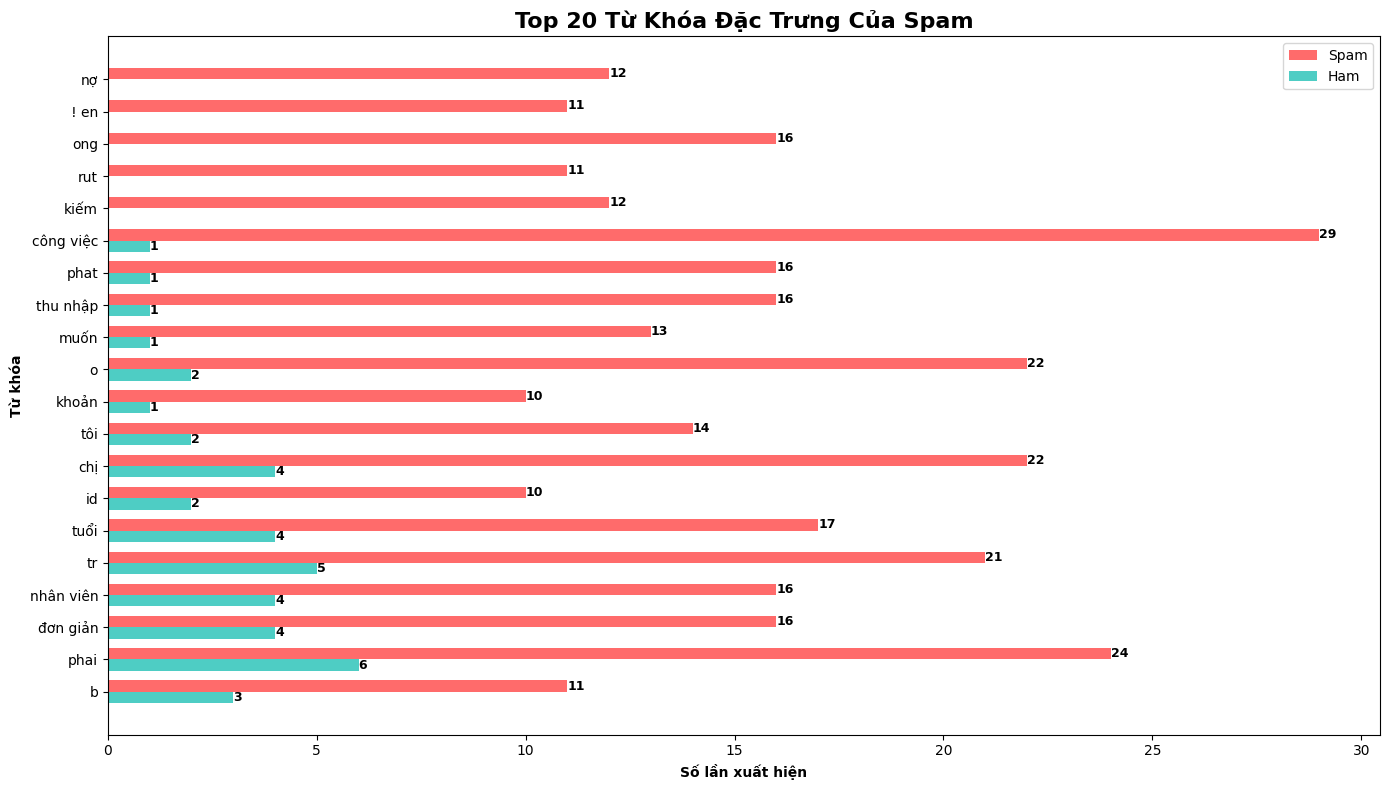

In [27]:
# Vẽ biểu đồ top từ khóa đặc trưng
import matplotlib.pyplot as plt

# Lấy top 20 từ đặc trưng nhất
top_words = sorted_distinctive[:20]
words = [w[0] for w in top_words]
spam_counts = [w[1]['spam_count'] for w in top_words]
ham_counts = [w[1]['ham_count'] for w in top_words]

# Vẽ biểu đồ so sánh
x = np.arange(len(words))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 8))
bars1 = ax.barh(x - width/2, spam_counts, width, label='Spam', color='#ff6b6b')
bars2 = ax.barh(x + width/2, ham_counts, width, label='Ham', color='#4ecdc4')

ax.set_ylabel('Từ khóa', fontweight='bold')
ax.set_xlabel('Số lần xuất hiện', fontweight='bold')
ax.set_title('Top 20 Từ Khóa Đặc Trưng Của Spam', fontsize=16, fontweight='bold')
ax.set_yticks(x)
ax.set_yticklabels(words)
ax.legend()
ax.invert_yaxis()  # Từ có điểm cao nhất ở trên

# Thêm giá trị vào bars
for bars in [bars1, bars2]:
    for bar in bars:
        width_bar = bar.get_width()
        if width_bar > 0:
            ax.text(width_bar, bar.get_y() + bar.get_height()/2, 
                   f'{int(width_bar)}', 
                   ha='left', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

In [29]:
# Phân nhóm từ khóa spam theo chủ đề
spam_keywords = {
    'Khuyến mãi/Giảm giá': ['khuyến mãi', 'giảm giá', 'sale', 'giảm', 'khuyến', 'mãi', 
                             'ưu đãi', 'voucher', 'deal', 'combo'],
    'Miễn phí/Tặng': ['miễn phí', 'free', 'tặng', 'quà', 'nhận', 'tri ân'],
    'Tiền/Tài chính': ['tiền', 'đồng', 'vnd', 'k', 'triệu', 'nghìn', 'vnđ',
                       'rút', 'nạp', 'chuyển khoản', 'tài khoản'],
    'Hành động khẩn cấp': ['ngay', 'nhanh', 'gấp', 'lập tức', 'vui lòng', 
                           'nhanh tay', 'chỉ', 'còn', 'hạn'],
    'Liên hệ': ['gọi', 'call', 'inbox', 'liên hệ', 'nhắn', 'sdt', 'zalo'],
    'Dịch vụ': ['dịch vụ', 'đăng ký', 'gói', 'gói cước', 'thuê bao', 'data']
}

print("\n" + "="*60)
print("PHÂN TÍCH NHÓM TỪ KHÓA TRONG SPAM")
print("="*60)

for category, keywords in spam_keywords.items():
    total_count = sum(spam_counter[kw] for kw in keywords if kw in spam_counter)
    print(f"\n{category}:")
    print(f"  Tổng xuất hiện: {total_count} lần")
    print(f"  Top từ:")
    for kw in keywords:
        if kw in spam_counter and spam_counter[kw] > 5:
            print(f"    - {kw}: {spam_counter[kw]} lần")


PHÂN TÍCH NHÓM TỪ KHÓA TRONG SPAM

Khuyến mãi/Giảm giá:
  Tổng xuất hiện: 15 lần
  Top từ:
    - ưu đãi: 8 lần

Miễn phí/Tặng:
  Tổng xuất hiện: 82 lần
  Top từ:
    - miễn phí: 11 lần
    - tặng: 17 lần
    - quà: 10 lần
    - nhận: 41 lần

Tiền/Tài chính:
  Tổng xuất hiện: 197 lần
  Top từ:
    - tiền: 27 lần
    - vnd: 20 lần
    - k: 88 lần
    - triệu: 13 lần
    - nạp: 16 lần
    - tài khoản: 23 lần

Hành động khẩn cấp:
  Tổng xuất hiện: 149 lần
  Top từ:
    - ngay: 75 lần
    - nhanh: 7 lần
    - vui lòng: 45 lần
    - chỉ: 7 lần
    - hạn: 8 lần

Liên hệ:
  Tổng xuất hiện: 110 lần
  Top từ:
    - gọi: 9 lần
    - liên hệ: 44 lần
    - nhắn: 17 lần
    - zalo: 39 lần

Dịch vụ:
  Tổng xuất hiện: 30 lần
  Top từ:
    - dịch vụ: 16 lần
    - đăng ký: 13 lần
